In [4]:
from deepforest import main
import glob
import fiona
import rioxarray as rx
#from deepforest import get_data
from deepforest import utilities
from deepforest import preprocess
from deepforest import evaluate
from deepforest import visualize
from itertools import product
from descartes import PolygonPatch
import tifffile as tiff
import cv2
import rasterio
from rasterio.crs import CRS
import os
import matplotlib.pyplot as plt
import matplotlib.image as mimage
import pandas as pd
from shapely.geometry import box
import geopandas as gpd
import numpy as np
import time
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.tensorboard import SummaryWriter, summary
import torch

writer = SummaryWriter()

import warnings
warnings.filterwarnings("ignore")

2025-03-11 14:38:50.366688: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def make_dirs(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    return dir_path

# Setup field of view

# Build dataset

# Build data sets (train, val, test)

In [6]:
# manual check on patches (won't work here now)


df = pd.read_csv('Train_Img_New3/summary_data.csv')

img = cv2.imread('Train_Img_New3/NS7993.jpg')

df = df[df.image_path=='NS7993.jpg']


color = (0, 0, 255)
thickness = 2

for index, row in df.iterrows():
    start_point = (int(row.xmin),int(row.ymin))   #xmin, ymin
    end_point   = (int(row.xmax),int(row.ymax))   #xmax, ymax

    cv2.rectangle(img, start_point, end_point, color, thickness)

# show it
plt.figure(figsize=(15,15))
plt.imshow(img[:500,:500])
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

FileNotFoundError: [Errno 2] No such file or directory: 'Train_Img_New3/summary_data.csv'

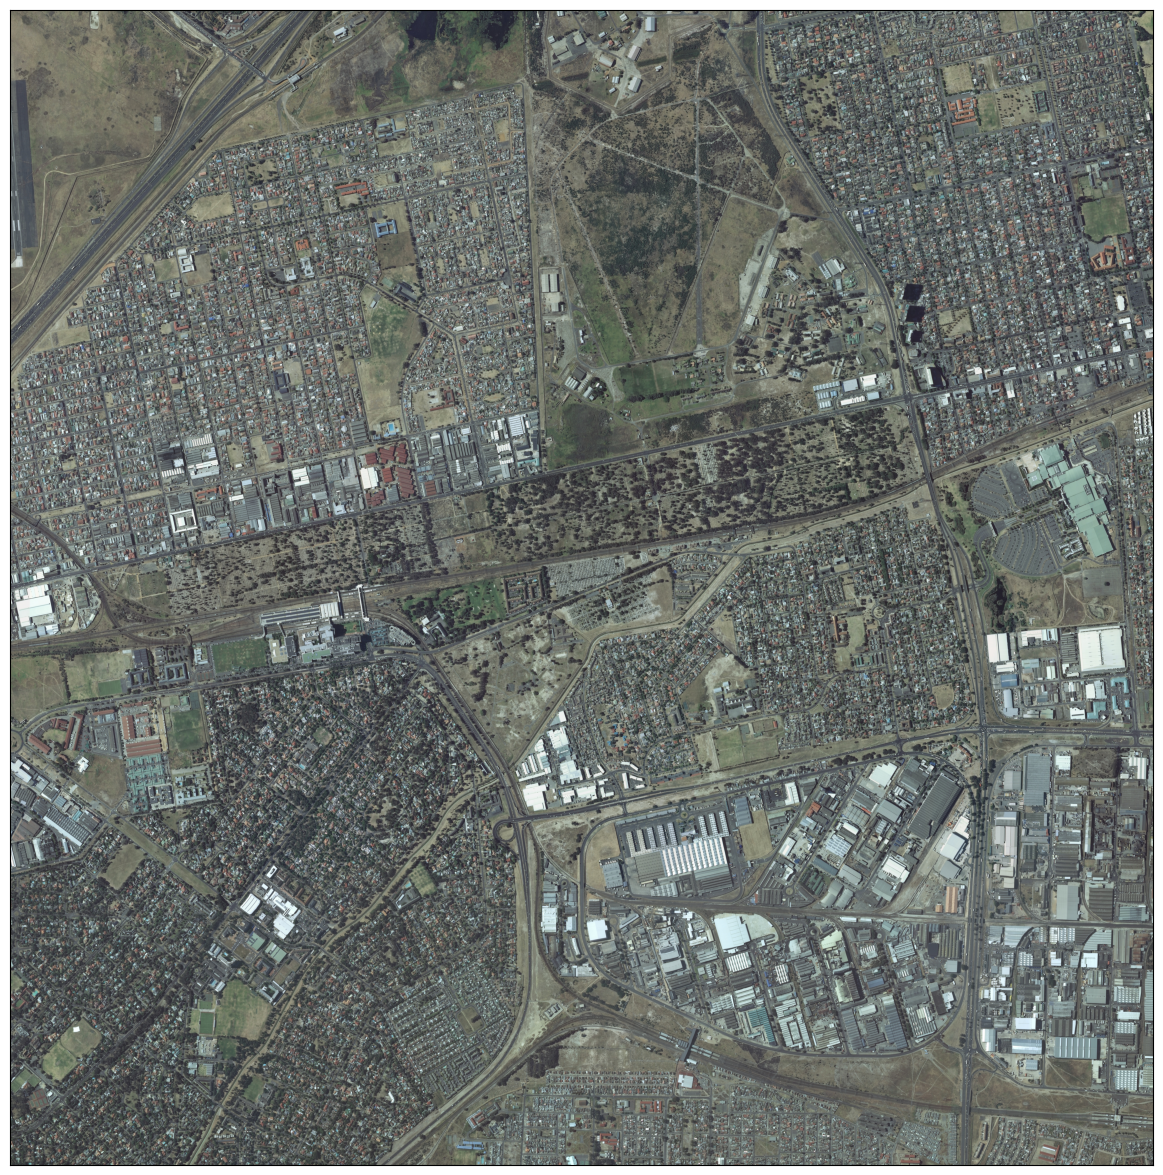

In [9]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load the TIFF image
with rasterio.open('../3318DC_16_2016_1143_RGB_RECT.tif') as tif:
    img = tif.read([1, 2, 3])  # Reading the first three bands (RGB)
    img = np.moveaxis(img, 0, -1)  # Reorder dimensions from (bands, height, width) to (height, width, bands)

# Convert image to uint8 if necessary
if img.dtype != np.uint8:
    img = (255 * (img - img.min()) / (img.max() - img.min())).astype(np.uint8)

# Show the image
plt.figure(figsize=(15, 15))
plt.imshow(img[:10000, :10000])
plt.xticks([]), plt.yticks([])  # Hide tick values on X and Y axis
plt.show()

In [11]:
import rasterio

# Open the TIFF file
with rasterio.open("../3318DC_16_2016_1143_RGB_RECT.tif") as src:
    print("CRS:", src.crs)  # Coordinate Reference System (e.g., EPSG:4326 for WGS84)
    print("Bounds:", src.bounds)  # Bounding box in projected coordinates

CRS: PROJCS["Projection: Transverse Mercator; Datum: WGS84; Ellipsoid: WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",19],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Bounds: BoundingBox(left=-46396.67499191616, bottom=-3758378.458007392, right=-41447.17499191616, top=-3752510.458007392)


In [ ]:
# train_images = sorted(glob.glob('Train_Img_New3/NS*.jpg'))
# train_images[:]

['Train_Img_New3/NS7792.jpg',
 'Train_Img_New3/NS7796.jpg',
 'Train_Img_New3/NS7890.jpg',
 'Train_Img_New3/NS7891.jpg',
 'Train_Img_New3/NS7892.jpg',
 'Train_Img_New3/NS7893.jpg',
 'Train_Img_New3/NS7894.jpg',
 'Train_Img_New3/NS7991.jpg',
 'Train_Img_New3/NS7992.jpg',
 'Train_Img_New3/NS7993.jpg']

In [27]:
for t in train_images:
    _ = preprocess.split_raster(path_to_raster=t,
                            annotations_file='Train_Img_New3/summary_data.csv',
                            base_dir=make_dirs(f'train_img/P300'),
                            patch_size=300,
                            patch_overlap=0.05,                           
                            allow_empty=False)

In [28]:
pd.concat([pd.read_csv(r) for r in glob.glob('train_img/P256/*csv')]).to_csv('train_img/P256/train_annotation.csv',index=False)
pd.concat([pd.read_csv(r) for r in glob.glob('train_img/P300/*csv')]).to_csv('train_img/P300/train_annotation.csv',index=False)
len(glob.glob('train_img/P256/*png')),len(glob.glob('train_img/P300/*png'))

(1290, 998)

In [9]:
pd.read_csv('train_img/P256/train_annotation.csv').shape

(3290, 6)

In [183]:
patch = [256,300,400]
for p in patch:
    for t in train_list:
        _ = preprocess.split_raster(path_to_raster=t,
                            annotations_file='Train_Img_New/summary_data.csv',
                            base_dir=make_dirs(f'train_img/P{p}'),
                            patch_size=p,
                            patch_overlap=0.05,                           
                            allow_empty=False)

In [184]:
# len(glob.glob('train_img/P256/*png')), len(glob.glob('train_img/P300/*png')), len(glob.glob('train_img/P400/*png'))

(811, 666, 573)

In [185]:
# pd.concat([pd.read_csv(r) for r in glob.glob('train_img/P256/*csv')]).to_csv('train_img/P256/train_annotation.csv',index=False)
# pd.concat([pd.read_csv(r) for r in glob.glob('train_img/P300/*csv')]).to_csv('train_img/P300/train_annotation.csv',index=False)
# pd.concat([pd.read_csv(r) for r in glob.glob('train_img/P400/*csv')]).to_csv('train_img/P400/train_annotation.csv',index=False)

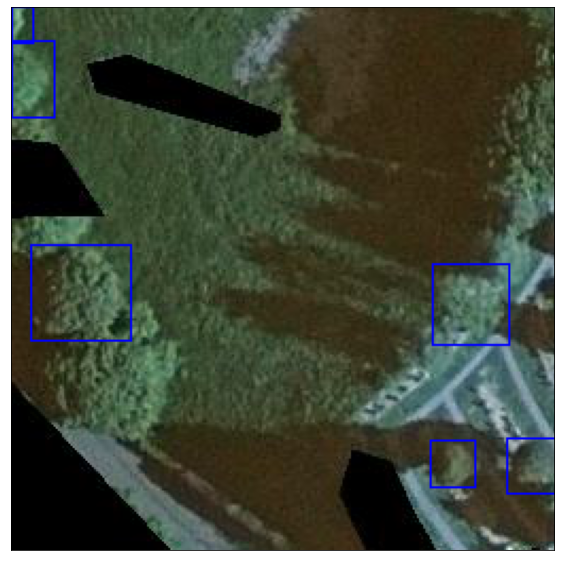

(256, 256, 3)


In [11]:
# manual check on patches (won't work here now)


df = pd.read_csv('train_img/P256/train_annotation.csv')
img = cv2.imread('train_img/P256/NS7792_273.png')

df = df[df.image_path=='NS7792_273.png']


color = (0, 0, 255)
thickness = 1

for index, row in df.iterrows():
    start_point = (int(row.xmin),int(row.ymin))   #xmin, ymin
    end_point   = (int(row.xmax),int(row.ymax))   #xmax, ymax

    cv2.rectangle(img, start_point, end_point, color, thickness)

# show it
plt.figure(figsize=(10,10))
plt.imshow(img[:,:])
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

print(img.shape)

In [19]:
def TrainModel(path_to_images, path_annotation, learning_rate, epochs, patch=None):
    model = main.deepforest()
    model.config['gpus'] = '-1' 
    model.config["train"]["csv_file"] = path_annotation
    model.config["train"]["root_dir"] = path_to_images
    model.config["score_thresh"] = 0.4
    model.config["lr"] = learning_rate
    model.config["train"]['epochs'] = epochs
    # model.config["validation"]["csv_file"] = path_annotation
    # model.config["validation"]["root_dir"] = path_to_images
    model.create_trainer(logger=TensorBoardLogger(save_dir='./runs', name=f'{patch}-24th'))
    model.trainer.fit(model)
    return model

In [29]:
%%time
for p in [256,300]:
    # start_time = time.time()
    start_time = time.time()
    model = TrainModel(path_to_images=f'train_img/P{p}/', path_annotation=f'train_img/P{p}/train_annotation.csv', learning_rate = 0.01, epochs=10)
    print(f"--- Training on GPU: {(time.time() - start_time)/60:.2f} minutes ---")
    torch.save(model.model.state_dict(), f'models/P{p}_modelB.tar')

Reading config file: /home/mortimer/anaconda3/envs/deep_env/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | RetinaNet | 32.1 M
------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

--- Training on GPU: 30.12 minutes ---
Reading config file: /home/mortimer/anaconda3/envs/deep_env/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | RetinaNet | 32.1 M
------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

--- Training on GPU: 23.38 minutes ---
CPU times: user 53min 29s, sys: 12.7 s, total: 53min 42s
Wall time: 53min 30s


In [21]:
test_images = glob.glob('Stirling_Img/NS*jpg')
test_images[:5]

['Stirling_Img/NS8092.jpg',
 'Stirling_Img/NS7894.jpg',
 'Stirling_Img/NS8296.jpg',
 'Stirling_Img/NS7692.jpg',
 'Stirling_Img/NS8090.jpg']

In [31]:
deep_models = glob.glob('./models/*modelB*tar')
deep_models


['./models/P256_modelB.tar', './models/P300_modelB.tar']

In [32]:
model_pred = main.deepforest()
model_pred.config['gpus'] = '-1'

for p in [256,300]:
    model_pred.model.load_state_dict(torch.load(f'models/P{p}_modelB.tar'))
    gdf_ls=[]
    for t in test_images:
        name = os.path.basename(t)
        img = rasterio.open(t)
        whole_im = model_pred.predict_tile(raster_path=t, patch_size=p)
        whole_im['image_path'] = name
        print(name)
        gdf_ls.append(utilities.annotations_to_shapefile(df=whole_im, transform=img.transform, crs=CRS.from_epsg(27700)))
    geo_df = pd.concat(gdf_ls)
            
    geo_df['area'] = geo_df.geometry.area
    geo_df['buffer'] = 1.5*np.sqrt(geo_df.area)/np.pi
    geo_df.to_file(f'New_test/P{p}_bboxC.shp')

Reading config file: /home/mortimer/anaconda3/envs/deep_env/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


100%|██████████| 289/289 [00:16<00:00, 17.63it/s]


1790 predictions in overlapping windows, applying non-max supression
1543 predictions kept after non-max suppression
NS8092.jpg


100%|██████████| 289/289 [00:16<00:00, 17.63it/s]


2836 predictions in overlapping windows, applying non-max supression
2424 predictions kept after non-max suppression
NS7894.jpg


100%|██████████| 289/289 [00:16<00:00, 17.42it/s]


2797 predictions in overlapping windows, applying non-max supression
2315 predictions kept after non-max suppression
NS8296.jpg


100%|██████████| 289/289 [00:16<00:00, 17.28it/s]


3215 predictions in overlapping windows, applying non-max supression
2565 predictions kept after non-max suppression
NS7692.jpg


100%|██████████| 289/289 [00:16<00:00, 17.01it/s]


3011 predictions in overlapping windows, applying non-max supression
2536 predictions kept after non-max suppression
NS8090.jpg


100%|██████████| 289/289 [00:16<00:00, 17.14it/s]


1055 predictions in overlapping windows, applying non-max supression
872 predictions kept after non-max suppression
NS7695.jpg


100%|██████████| 289/289 [00:17<00:00, 16.94it/s]


2447 predictions in overlapping windows, applying non-max supression
1991 predictions kept after non-max suppression
NS7896.jpg


100%|██████████| 289/289 [00:17<00:00, 16.95it/s]


1522 predictions in overlapping windows, applying non-max supression
1316 predictions kept after non-max suppression
NS8189.jpg


100%|██████████| 289/289 [00:17<00:00, 16.85it/s]


3075 predictions in overlapping windows, applying non-max supression
2552 predictions kept after non-max suppression
NS8192.jpg


100%|██████████| 289/289 [00:17<00:00, 16.96it/s]


1792 predictions in overlapping windows, applying non-max supression
1503 predictions kept after non-max suppression
NS7890.jpg


100%|██████████| 289/289 [00:17<00:00, 16.82it/s]


4435 predictions in overlapping windows, applying non-max supression
3678 predictions kept after non-max suppression
NS7792.jpg


100%|██████████| 289/289 [00:17<00:00, 16.78it/s]


3254 predictions in overlapping windows, applying non-max supression
2740 predictions kept after non-max suppression
NS8190.jpg


100%|██████████| 289/289 [00:17<00:00, 16.71it/s]


4719 predictions in overlapping windows, applying non-max supression
3926 predictions kept after non-max suppression
NS7892.jpg


100%|██████████| 289/289 [00:17<00:00, 16.90it/s]


1388 predictions in overlapping windows, applying non-max supression
1099 predictions kept after non-max suppression
NS7793.jpg


100%|██████████| 289/289 [00:17<00:00, 16.88it/s]


1830 predictions in overlapping windows, applying non-max supression
1511 predictions kept after non-max suppression
NS8297.jpg


100%|██████████| 289/289 [00:17<00:00, 16.87it/s]


2774 predictions in overlapping windows, applying non-max supression
2358 predictions kept after non-max suppression
NS7794.jpg


100%|██████████| 289/289 [00:17<00:00, 16.94it/s]


1391 predictions in overlapping windows, applying non-max supression
1173 predictions kept after non-max suppression
NS7696.jpg


100%|██████████| 289/289 [00:17<00:00, 16.82it/s]


3917 predictions in overlapping windows, applying non-max supression
3260 predictions kept after non-max suppression
NS8096.jpg


100%|██████████| 289/289 [00:17<00:00, 16.84it/s]


5300 predictions in overlapping windows, applying non-max supression
4354 predictions kept after non-max suppression
NS7790.jpg


100%|██████████| 289/289 [00:17<00:00, 16.88it/s]


2348 predictions in overlapping windows, applying non-max supression
1971 predictions kept after non-max suppression
NS8094.jpg


100%|██████████| 289/289 [00:17<00:00, 16.67it/s]


9517 predictions in overlapping windows, applying non-max supression
7860 predictions kept after non-max suppression
NS7791.jpg


100%|██████████| 289/289 [00:17<00:00, 16.76it/s]


6395 predictions in overlapping windows, applying non-max supression
5436 predictions kept after non-max suppression
NS7691.jpg


100%|██████████| 289/289 [00:16<00:00, 17.04it/s]


1264 predictions in overlapping windows, applying non-max supression
1006 predictions kept after non-max suppression
NS7693.jpg


100%|██████████| 289/289 [00:17<00:00, 16.91it/s]


1951 predictions in overlapping windows, applying non-max supression
1685 predictions kept after non-max suppression
NS7990.jpg


100%|██████████| 289/289 [00:17<00:00, 16.81it/s]


3417 predictions in overlapping windows, applying non-max supression
2768 predictions kept after non-max suppression
NS7893.jpg


100%|██████████| 289/289 [00:17<00:00, 16.83it/s]


3461 predictions in overlapping windows, applying non-max supression
2832 predictions kept after non-max suppression
NS7993.jpg


100%|██████████| 289/289 [00:17<00:00, 16.77it/s]


3109 predictions in overlapping windows, applying non-max supression
2588 predictions kept after non-max suppression
NS7795.jpg


100%|██████████| 289/289 [00:17<00:00, 16.86it/s]


2645 predictions in overlapping windows, applying non-max supression
2236 predictions kept after non-max suppression
NS8089.jpg


100%|██████████| 289/289 [00:17<00:00, 16.84it/s]


4131 predictions in overlapping windows, applying non-max supression
3478 predictions kept after non-max suppression
NS7891.jpg


100%|██████████| 289/289 [00:17<00:00, 16.77it/s]


4395 predictions in overlapping windows, applying non-max supression
3704 predictions kept after non-max suppression
NS7992.jpg


100%|██████████| 289/289 [00:17<00:00, 16.92it/s]


2235 predictions in overlapping windows, applying non-max supression
1944 predictions kept after non-max suppression
NS7996.jpg


100%|██████████| 289/289 [00:17<00:00, 16.80it/s]


3908 predictions in overlapping windows, applying non-max supression
3257 predictions kept after non-max suppression
NS8095.jpg


100%|██████████| 289/289 [00:17<00:00, 16.74it/s]


3851 predictions in overlapping windows, applying non-max supression
3189 predictions kept after non-max suppression
NS7994.jpg


100%|██████████| 289/289 [00:17<00:00, 16.89it/s]


3183 predictions in overlapping windows, applying non-max supression
2664 predictions kept after non-max suppression
NS8088.jpg


100%|██████████| 289/289 [00:17<00:00, 16.80it/s]


3099 predictions in overlapping windows, applying non-max supression
2577 predictions kept after non-max suppression
NS7991.jpg


100%|██████████| 289/289 [00:17<00:00, 16.95it/s]


2198 predictions in overlapping windows, applying non-max supression
1815 predictions kept after non-max suppression
NS8295.jpg


100%|██████████| 289/289 [00:17<00:00, 16.82it/s]


4327 predictions in overlapping windows, applying non-max supression
3723 predictions kept after non-max suppression
NS8196.jpg


100%|██████████| 289/289 [00:17<00:00, 16.88it/s]


2377 predictions in overlapping windows, applying non-max supression
2047 predictions kept after non-max suppression
NS8193.jpg


100%|██████████| 289/289 [00:17<00:00, 16.87it/s]


1407 predictions in overlapping windows, applying non-max supression
1184 predictions kept after non-max suppression
NS8194.jpg


100%|██████████| 289/289 [00:17<00:00, 16.83it/s]


2834 predictions in overlapping windows, applying non-max supression
2340 predictions kept after non-max suppression
NS7995.jpg


100%|██████████| 289/289 [00:17<00:00, 16.89it/s]


2328 predictions in overlapping windows, applying non-max supression
1874 predictions kept after non-max suppression
NS7895.jpg


100%|██████████| 289/289 [00:17<00:00, 16.93it/s]


1776 predictions in overlapping windows, applying non-max supression
1518 predictions kept after non-max suppression
NS8294.jpg


100%|██████████| 289/289 [00:17<00:00, 16.85it/s]


2243 predictions in overlapping windows, applying non-max supression
1902 predictions kept after non-max suppression
NS8093.jpg


100%|██████████| 289/289 [00:17<00:00, 16.88it/s]


3079 predictions in overlapping windows, applying non-max supression
2634 predictions kept after non-max suppression
NS8191.jpg


100%|██████████| 289/289 [00:17<00:00, 16.81it/s]


5499 predictions in overlapping windows, applying non-max supression
4444 predictions kept after non-max suppression
NS8197.jpg


100%|██████████| 289/289 [00:16<00:00, 17.07it/s]


975 predictions in overlapping windows, applying non-max supression
841 predictions kept after non-max suppression
NS7796.jpg


100%|██████████| 289/289 [00:17<00:00, 16.96it/s]


1753 predictions in overlapping windows, applying non-max supression
1426 predictions kept after non-max suppression
NS7989.jpg


100%|██████████| 289/289 [00:17<00:00, 16.82it/s]


3273 predictions in overlapping windows, applying non-max supression
2821 predictions kept after non-max suppression
NS8195.jpg


100%|██████████| 289/289 [00:17<00:00, 16.81it/s]


5806 predictions in overlapping windows, applying non-max supression
4719 predictions kept after non-max suppression
NS8097.jpg


100%|██████████| 289/289 [00:17<00:00, 16.80it/s]


3636 predictions in overlapping windows, applying non-max supression
3044 predictions kept after non-max suppression
NS8091.jpg


100%|██████████| 196/196 [00:11<00:00, 16.91it/s]


1301 predictions in overlapping windows, applying non-max supression
1173 predictions kept after non-max suppression
NS8092.jpg


100%|██████████| 196/196 [00:11<00:00, 16.94it/s]


2159 predictions in overlapping windows, applying non-max supression
1952 predictions kept after non-max suppression
NS7894.jpg


100%|██████████| 196/196 [00:17<00:00, 11.33it/s]


2106 predictions in overlapping windows, applying non-max supression
1915 predictions kept after non-max suppression
NS8296.jpg


100%|██████████| 196/196 [00:24<00:00,  8.16it/s]


2142 predictions in overlapping windows, applying non-max supression
1924 predictions kept after non-max suppression
NS7692.jpg


100%|██████████| 196/196 [00:11<00:00, 16.77it/s]


2043 predictions in overlapping windows, applying non-max supression
1805 predictions kept after non-max suppression
NS8090.jpg


100%|██████████| 196/196 [00:11<00:00, 16.98it/s]


785 predictions in overlapping windows, applying non-max supression
713 predictions kept after non-max suppression
NS7695.jpg


100%|██████████| 196/196 [00:11<00:00, 16.82it/s]


1826 predictions in overlapping windows, applying non-max supression
1610 predictions kept after non-max suppression
NS7896.jpg


100%|██████████| 196/196 [00:11<00:00, 16.86it/s]


1098 predictions in overlapping windows, applying non-max supression
981 predictions kept after non-max suppression
NS8189.jpg


100%|██████████| 196/196 [00:11<00:00, 16.73it/s]


2266 predictions in overlapping windows, applying non-max supression
2007 predictions kept after non-max suppression
NS8192.jpg


100%|██████████| 196/196 [00:11<00:00, 16.87it/s]


1440 predictions in overlapping windows, applying non-max supression
1279 predictions kept after non-max suppression
NS7890.jpg


100%|██████████| 196/196 [00:11<00:00, 16.78it/s]


2937 predictions in overlapping windows, applying non-max supression
2632 predictions kept after non-max suppression
NS7792.jpg


100%|██████████| 196/196 [00:11<00:00, 16.80it/s]


2289 predictions in overlapping windows, applying non-max supression
2031 predictions kept after non-max suppression
NS8190.jpg


100%|██████████| 196/196 [00:11<00:00, 16.69it/s]


3472 predictions in overlapping windows, applying non-max supression
3047 predictions kept after non-max suppression
NS7892.jpg


100%|██████████| 196/196 [00:11<00:00, 16.91it/s]


941 predictions in overlapping windows, applying non-max supression
867 predictions kept after non-max suppression
NS7793.jpg


100%|██████████| 196/196 [00:11<00:00, 16.94it/s]


994 predictions in overlapping windows, applying non-max supression
896 predictions kept after non-max suppression
NS8297.jpg


100%|██████████| 196/196 [00:11<00:00, 16.86it/s]


2170 predictions in overlapping windows, applying non-max supression
1913 predictions kept after non-max suppression
NS7794.jpg


100%|██████████| 196/196 [00:11<00:00, 16.93it/s]


985 predictions in overlapping windows, applying non-max supression
892 predictions kept after non-max suppression
NS7696.jpg


100%|██████████| 196/196 [00:11<00:00, 16.70it/s]


2953 predictions in overlapping windows, applying non-max supression
2618 predictions kept after non-max suppression
NS8096.jpg


100%|██████████| 196/196 [00:11<00:00, 16.78it/s]


3365 predictions in overlapping windows, applying non-max supression
3015 predictions kept after non-max suppression
NS7790.jpg


100%|██████████| 196/196 [00:11<00:00, 16.84it/s]


1642 predictions in overlapping windows, applying non-max supression
1478 predictions kept after non-max suppression
NS8094.jpg


100%|██████████| 196/196 [00:11<00:00, 16.72it/s]


5658 predictions in overlapping windows, applying non-max supression
5004 predictions kept after non-max suppression
NS7791.jpg


100%|██████████| 196/196 [00:11<00:00, 16.75it/s]


4500 predictions in overlapping windows, applying non-max supression
4014 predictions kept after non-max suppression
NS7691.jpg


100%|██████████| 196/196 [00:11<00:00, 17.01it/s]


1026 predictions in overlapping windows, applying non-max supression
914 predictions kept after non-max suppression
NS7693.jpg


100%|██████████| 196/196 [00:11<00:00, 16.81it/s]


1548 predictions in overlapping windows, applying non-max supression
1383 predictions kept after non-max suppression
NS7990.jpg


100%|██████████| 196/196 [00:11<00:00, 16.76it/s]


2581 predictions in overlapping windows, applying non-max supression
2295 predictions kept after non-max suppression
NS7893.jpg


100%|██████████| 196/196 [00:11<00:00, 16.76it/s]


2424 predictions in overlapping windows, applying non-max supression
2128 predictions kept after non-max suppression
NS7993.jpg


100%|██████████| 196/196 [00:11<00:00, 16.83it/s]


2300 predictions in overlapping windows, applying non-max supression
2011 predictions kept after non-max suppression
NS7795.jpg


100%|██████████| 196/196 [00:11<00:00, 16.82it/s]


1961 predictions in overlapping windows, applying non-max supression
1770 predictions kept after non-max suppression
NS8089.jpg


100%|██████████| 196/196 [00:11<00:00, 16.75it/s]


3024 predictions in overlapping windows, applying non-max supression
2672 predictions kept after non-max suppression
NS7891.jpg


100%|██████████| 196/196 [00:11<00:00, 16.69it/s]


3374 predictions in overlapping windows, applying non-max supression
2948 predictions kept after non-max suppression
NS7992.jpg


100%|██████████| 196/196 [00:11<00:00, 16.86it/s]


1896 predictions in overlapping windows, applying non-max supression
1663 predictions kept after non-max suppression
NS7996.jpg


100%|██████████| 196/196 [00:11<00:00, 16.75it/s]


2623 predictions in overlapping windows, applying non-max supression
2347 predictions kept after non-max suppression
NS8095.jpg


100%|██████████| 196/196 [00:11<00:00, 16.73it/s]


2894 predictions in overlapping windows, applying non-max supression
2546 predictions kept after non-max suppression
NS7994.jpg


100%|██████████| 196/196 [00:11<00:00, 16.84it/s]


2395 predictions in overlapping windows, applying non-max supression
2136 predictions kept after non-max suppression
NS8088.jpg


100%|██████████| 196/196 [00:11<00:00, 16.78it/s]


2203 predictions in overlapping windows, applying non-max supression
1982 predictions kept after non-max suppression
NS7991.jpg


100%|██████████| 196/196 [00:11<00:00, 16.87it/s]


1777 predictions in overlapping windows, applying non-max supression
1568 predictions kept after non-max suppression
NS8295.jpg


100%|██████████| 196/196 [00:11<00:00, 16.71it/s]


3308 predictions in overlapping windows, applying non-max supression
2934 predictions kept after non-max suppression
NS8196.jpg


100%|██████████| 196/196 [00:11<00:00, 16.80it/s]


1809 predictions in overlapping windows, applying non-max supression
1631 predictions kept after non-max suppression
NS8193.jpg


100%|██████████| 196/196 [00:11<00:00, 16.94it/s]


820 predictions in overlapping windows, applying non-max supression
750 predictions kept after non-max suppression
NS8194.jpg


100%|██████████| 196/196 [00:11<00:00, 16.82it/s]


2089 predictions in overlapping windows, applying non-max supression
1843 predictions kept after non-max suppression
NS7995.jpg


100%|██████████| 196/196 [00:11<00:00, 16.86it/s]


1573 predictions in overlapping windows, applying non-max supression
1413 predictions kept after non-max suppression
NS7895.jpg


100%|██████████| 196/196 [00:11<00:00, 16.88it/s]


1277 predictions in overlapping windows, applying non-max supression
1158 predictions kept after non-max suppression
NS8294.jpg


100%|██████████| 196/196 [00:11<00:00, 16.79it/s]


1706 predictions in overlapping windows, applying non-max supression
1531 predictions kept after non-max suppression
NS8093.jpg


100%|██████████| 196/196 [00:11<00:00, 16.83it/s]


2322 predictions in overlapping windows, applying non-max supression
2074 predictions kept after non-max suppression
NS8191.jpg


100%|██████████| 196/196 [00:11<00:00, 16.79it/s]


3647 predictions in overlapping windows, applying non-max supression
3255 predictions kept after non-max suppression
NS8197.jpg


100%|██████████| 196/196 [00:11<00:00, 17.01it/s]


784 predictions in overlapping windows, applying non-max supression
720 predictions kept after non-max suppression
NS7796.jpg


100%|██████████| 196/196 [00:11<00:00, 16.91it/s]


1293 predictions in overlapping windows, applying non-max supression
1154 predictions kept after non-max suppression
NS7989.jpg


100%|██████████| 196/196 [00:11<00:00, 16.84it/s]


2444 predictions in overlapping windows, applying non-max supression
2185 predictions kept after non-max suppression
NS8195.jpg


100%|██████████| 196/196 [00:11<00:00, 16.78it/s]


3959 predictions in overlapping windows, applying non-max supression
3538 predictions kept after non-max suppression
NS8097.jpg


100%|██████████| 196/196 [00:11<00:00, 16.69it/s]


2570 predictions in overlapping windows, applying non-max supression
2273 predictions kept after non-max suppression
NS8091.jpg


In [25]:
metrics = {'image':[], 'Recall':[], 'Precision':[]}
pred_df = gpd.read_file('New_test/P256_bboxB.shp')
ground_df = pd.read_csv('Test_Img_New3/summary_data.csv')
for n in test_images:
    result12 = evaluate.evaluate(predictions=pred_df[pred_df.image_path==os.path.basename(n)],
                                    ground_df=ground_df[ground_df.image_path==os.path.basename(n)],
                                    root_dir='Test_Img_New3/',
                                    iou_threshold=0.4,
                                    savedir='/')
    metrics['image'].append(os.path.basename(n))
    metrics['Recall'].append(result12['box_recall'])
    metrics['Precision'].append(result12['box_precision'])

No predictions made
No predictions made
No predictions made


ValueError: No objects to concatenate

In [31]:
pd.DataFrame(metrics)

image    Recall  Precision
0   NS8090.jpg  0.250000   0.000257
1   NS8091.jpg  0.278261   0.008815
2   NS8092.jpg  0.292683   0.003915
3   NS8093.jpg  0.471264   0.014226
4   NS8094.jpg  0.585185   0.032364
5   NS8095.jpg  0.288660   0.008706
6   NS8192.jpg  0.471698   0.010500
7   NS8193.jpg  0.296296   0.009206
8   NS8194.jpg  0.390244   0.028777
9   NS8195.jpg  0.469388   0.010921
10  NS8294.jpg  0.516129   0.035714
11  NS8295.jpg  0.611940   0.029927
12  NS8296.jpg  0.513158   0.028343
13  NS8297.jpg  0.553191   0.023615

In [26]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [192]:
%%time
# start_time = time.time()
for p in [256,300,400]:
    start_time = time.time()
    model = TrainModel(path_to_images=f'train_img/P{p}', path_annotation=f'train_img/P{p}/train_annotation.csv', learning_rate = 0.01, patch=p, epochs=5)
    torch.save(model.model.state_dict(), f'models/P{p}_model_lr.tar')
    gdf_ls=[]
    for t in tesst_list:
        name = os.path.basename(t)
        img = rasterio.open(t)
        whole_im = model.predict_tile(raster_path=t, patch_size=p)
        whole_im['image_path'] = name
        print(name)
        gdf_ls.append(utilities.annotations_to_shapefile(df=whole_im, transform=img.transform, crs=CRS.from_epsg(27700)))
    geo_df = pd.concat(gdf_ls)
        
    geo_df['area'] = geo_df.geometry.area
    geo_df['buffer'] = 1.5*np.sqrt(geo_df.area)/np.pi
    geo_df.to_file(f'New_test/P{p}_bbox.shp')

Reading config file: /home/mortimer/anaconda3/envs/deep_env/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logdir1/400-0.01-5-40-0.375
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | RetinaNet | 32.1 M
------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

100%|████████████████████████████████████████████████████████████████| 121/121 [00:06<00:00, 17.32it/s]

No predictions made, returning None
No predictions made, returning None


TypeError: 'NoneType' object does not support item assignment

In [6]:
%load_ext tensorboard
%tensorboard --logdir=logdir1

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [146]:
models = glob.glob('models/P400*0.*.tar')
models

['models/P400_model_lr0.4.tar',
 'models/P400_model_lr0.01.tar',
 'models/P400_model_lr0.1.tar',
 'models/P400_model_lr0.001.tar']

In [141]:
model_pred = main.deepforest()
model_pred.config['gpus'] = '-1'

Reading config file: /home/mortimer/anaconda3/envs/deep_env/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


In [150]:
for m in models[3:]:
    model_pred.model.load_state_dict(torch.load(m))
    print(m)
    params = os.path.basename(m).split('_')
    p = params[0][1:]
    lr = params[-1][:-4]
    print(p)
    gdf_ls=[]
    for t in train_images[5:10]:
        name = os.path.basename(t)
        file = f'Stirling_Img/{name}'
        print(file)
        img = rasterio.open(file)
        whole_im = model_pred.predict_tile(raster_path=file, patch_size=int(p))
        whole_im['image_path'] = name
        print(name)
        gdf_ls.append(utilities.annotations_to_shapefile(df=whole_im, transform=img.transform, crs=CRS.from_epsg(27700)))
    geo_df = pd.concat(gdf_ls)
        
    geo_df['area'] = geo_df.geometry.area
    geo_df['buffer'] = 1.5*np.sqrt(geo_df.area)/np.pi
    geo_df.to_file(f'New_test/P{p}_bbox({lr}).shp')

models/P400_model_lr0.001.tar
400
Stirling_Img/NS7893.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:06<00:00, 18.16it/s]

No predictions made, returning None
No predictions made, returning None


TypeError: 'NoneType' object does not support item assignment

In [102]:
for p in [256, 300, 400]:
    for r in [0.001, 0.01, 0.1, 0.4]:
        model_pred.model.load_state_dict(torch.load(f'models/P{p}_model_lr{r}.tar'))
        gdf_ls=[]
        for t in train_images[25:]:
            name = os.path.basename(t)
            file = f'Stirling_Img/{name}'
            print(file)
            img = rasterio.open(file)
        
            whole_im = model_pred.predict_tile(raster_path=file, patch_size=p)
            whole_im['image_path'] = name
            print(name)
            gdf_ls.append(utilities.annotations_to_shapefile(df=whole_im, transform=img.transform, crs=CRS.from_epsg(27700)))

        geo_df = pd.concat(gdf_ls)

        geo_df['area'] = geo_df.geometry.area
        geo_df['buffer'] = 1.5*np.sqrt(geo_df.area)/np.pi
        geo_df.to_file(f'New_test/P{p}_bbox({r}).shp')

Stirling_Img/NS8194.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:16<00:00, 17.78it/s]


1146 predictions in overlapping windows, applying non-max supression
914 predictions kept after non-max suppression
NS8194.jpg
Stirling_Img/NS8195.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:16<00:00, 17.62it/s]


2242 predictions in overlapping windows, applying non-max supression
1904 predictions kept after non-max suppression
NS8195.jpg
Stirling_Img/NS8196.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:16<00:00, 17.28it/s]


3282 predictions in overlapping windows, applying non-max supression
2746 predictions kept after non-max suppression
NS8196.jpg
Stirling_Img/NS8197.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:16<00:00, 17.12it/s]


3428 predictions in overlapping windows, applying non-max supression
2763 predictions kept after non-max suppression
NS8197.jpg
Stirling_Img/NS8294.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:16<00:00, 17.11it/s]


1364 predictions in overlapping windows, applying non-max supression
1132 predictions kept after non-max suppression
NS8294.jpg
Stirling_Img/NS8295.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.98it/s]


1782 predictions in overlapping windows, applying non-max supression
1465 predictions kept after non-max suppression
NS8295.jpg
Stirling_Img/NS8296.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.92it/s]


2173 predictions in overlapping windows, applying non-max supression
1798 predictions kept after non-max suppression
NS8296.jpg
Stirling_Img/NS8297.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.98it/s]


1209 predictions in overlapping windows, applying non-max supression
978 predictions kept after non-max suppression
NS8297.jpg
Stirling_Img/NS8194.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.80it/s]


1518 predictions in overlapping windows, applying non-max supression
1286 predictions kept after non-max suppression
NS8194.jpg
Stirling_Img/NS8195.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.83it/s]


2942 predictions in overlapping windows, applying non-max supression
2578 predictions kept after non-max suppression
NS8195.jpg
Stirling_Img/NS8196.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.73it/s]


4154 predictions in overlapping windows, applying non-max supression
3624 predictions kept after non-max suppression
NS8196.jpg
Stirling_Img/NS8197.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.75it/s]


4562 predictions in overlapping windows, applying non-max supression
3731 predictions kept after non-max suppression
NS8197.jpg
Stirling_Img/NS8294.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.86it/s]


1889 predictions in overlapping windows, applying non-max supression
1616 predictions kept after non-max suppression
NS8294.jpg
Stirling_Img/NS8295.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.84it/s]


2313 predictions in overlapping windows, applying non-max supression
1938 predictions kept after non-max suppression
NS8295.jpg
Stirling_Img/NS8296.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.81it/s]


2926 predictions in overlapping windows, applying non-max supression
2482 predictions kept after non-max suppression
NS8296.jpg
Stirling_Img/NS8297.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.82it/s]


1848 predictions in overlapping windows, applying non-max supression
1561 predictions kept after non-max suppression
NS8297.jpg
Stirling_Img/NS8194.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.79it/s]


1800 predictions in overlapping windows, applying non-max supression
1375 predictions kept after non-max suppression
NS8194.jpg
Stirling_Img/NS8195.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.77it/s]


3222 predictions in overlapping windows, applying non-max supression
2656 predictions kept after non-max suppression
NS8195.jpg
Stirling_Img/NS8196.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.78it/s]


4505 predictions in overlapping windows, applying non-max supression
3747 predictions kept after non-max suppression
NS8196.jpg
Stirling_Img/NS8197.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.78it/s]


5249 predictions in overlapping windows, applying non-max supression
4124 predictions kept after non-max suppression
NS8197.jpg
Stirling_Img/NS8294.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.93it/s]


1943 predictions in overlapping windows, applying non-max supression
1578 predictions kept after non-max suppression
NS8294.jpg
Stirling_Img/NS8295.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.89it/s]


2343 predictions in overlapping windows, applying non-max supression
1866 predictions kept after non-max suppression
NS8295.jpg
Stirling_Img/NS8296.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.80it/s]


3293 predictions in overlapping windows, applying non-max supression
2604 predictions kept after non-max suppression
NS8296.jpg
Stirling_Img/NS8297.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:17<00:00, 16.87it/s]


1854 predictions in overlapping windows, applying non-max supression
1483 predictions kept after non-max suppression
NS8297.jpg
Stirling_Img/NS8194.jpg


100%|████████████████████████████████████████████████████████████████| 289/289 [00:16<00:00, 17.96it/s]

No predictions made, returning None
No predictions made, returning None


TypeError: 'NoneType' object does not support item assignment

In [35]:
def getRasterExtent(raster_image, crs):
    rst_bounds = rasterio.open(raster_image).bounds
    # print(*rst_bounds)
    ext_gdf = gpd.GeoDataFrame({'id':1, 'geometry':[box(*rst_bounds)]}, crs=crs)

    return ext_gdf


In [154]:
preds = glob.glob('New_test/*shp')
preds

['New_test/P256_bbox(lr0.001).shp',
 'New_test/P300_bbox(lr0.1).shp',
 'New_test/P256_bbox(lr0.1).shp',
 'New_test/P300_bbox(lr0.01).shp',
 'New_test/P300_bbox(lr0.001).shp',
 'New_test/P256_bbox(lr0.01).shp']

In [155]:
pred_imgs = train_images[5:10]
pred_imgs

['Train_Img_New/NS7893.jpg',
 'Train_Img_New/NS7894.jpg',
 'Train_Img_New/NS7895.jpg',
 'Train_Img_New/NS7990.jpg',
 'Train_Img_New/NS7991.jpg']

In [161]:
metrics = {'lr':[], 'Patch':[], 'image':[], 'Recall':[], 'Precision':[]}
for d in preds:
    lr = d.split('/')[-1].split('lr')[-1][:-5]
    print(lr)
    pred_df = gpd.read_file(d)
    ground_df = pd.read_csv('Train_Img_New/summary_data.csv')
    for n in pred_imgs:
        result12 = evaluate.evaluate(predictions=pred_df[pred_df.image_path==os.path.basename(n)],
                                    ground_df=ground_df[ground_df.image_path==os.path.basename(n)],
                                    root_dir='Train_Img_New/',
                                    iou_threshold=0.4,
                                    savedir='/')
        metrics['Patch'].append(os.path.basename(d)[:6])
        metrics['lr'].append(lr)
        metrics['image'].append(os.path.basename(n))
        metrics['Recall'].append(result12['box_recall'])
        metrics['Precision'].append(result12['box_precision'])

0.001


[ WARN:0@1137656.484] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7893.jpg'): can't open file for writing: permission denied
[ WARN:0@1137667.585] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7894.jpg'): can't open file for writing: permission denied
[ WARN:0@1137669.133] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7895.jpg'): can't open file for writing: permission denied
[ WARN:0@1137675.004] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7990.jpg'): can't open file for writing: permission denied
[ WARN:0@1137695.830] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/mod

0.1


[ WARN:0@1137722.226] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7893.jpg'): can't open file for writing: permission denied
[ WARN:0@1137731.073] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7894.jpg'): can't open file for writing: permission denied
[ WARN:0@1137731.974] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7895.jpg'): can't open file for writing: permission denied
[ WARN:0@1137736.409] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7990.jpg'): can't open file for writing: permission denied
[ WARN:0@1137752.256] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/mod

0.1


[ WARN:0@1137793.309] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7893.jpg'): can't open file for writing: permission denied
[ WARN:0@1137808.481] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7894.jpg'): can't open file for writing: permission denied
[ WARN:0@1137810.542] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7895.jpg'): can't open file for writing: permission denied
[ WARN:0@1137817.913] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7990.jpg'): can't open file for writing: permission denied
[ WARN:0@1137844.631] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/mod

0.01


[ WARN:0@1137865.654] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7893.jpg'): can't open file for writing: permission denied
[ WARN:0@1137872.491] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7894.jpg'): can't open file for writing: permission denied
[ WARN:0@1137873.527] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7895.jpg'): can't open file for writing: permission denied
[ WARN:0@1137877.012] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7990.jpg'): can't open file for writing: permission denied
[ WARN:0@1137890.016] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/mod

0.001


[ WARN:0@1137923.001] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7893.jpg'): can't open file for writing: permission denied
[ WARN:0@1137935.061] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7894.jpg'): can't open file for writing: permission denied
[ WARN:0@1137936.563] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7895.jpg'): can't open file for writing: permission denied
[ WARN:0@1137942.516] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7990.jpg'): can't open file for writing: permission denied
[ WARN:0@1137966.257] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/mod

0.01


[ WARN:0@1138006.656] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7893.jpg'): can't open file for writing: permission denied
[ WARN:0@1138022.759] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7894.jpg'): can't open file for writing: permission denied
[ WARN:0@1138024.390] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7895.jpg'): can't open file for writing: permission denied
[ WARN:0@1138032.576] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS7990.jpg'): can't open file for writing: permission denied
[ WARN:0@1138062.463] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/mod

In [162]:
met_df = pd.DataFrame(metrics)
met_df

lr   Patch       image    Recall  Precision
0   0.001  P256_b  NS7893.jpg  0.914573   0.074165
1   0.001  P256_b  NS7894.jpg  0.888889   0.036345
2   0.001  P256_b  NS7895.jpg  1.000000   0.003189
3   0.001  P256_b  NS7990.jpg  0.925926   0.034364
4   0.001  P256_b  NS7991.jpg  0.869863   0.061116
5     0.1  P300_b  NS7893.jpg  0.914573   0.095438
6     0.1  P300_b  NS7894.jpg  0.950617   0.050591
7     0.1  P300_b  NS7895.jpg  0.800000   0.003887
8     0.1  P300_b  NS7990.jpg  0.870370   0.047284
9     0.1  P300_b  NS7991.jpg  0.863014   0.080153
10    0.1  P256_b  NS7893.jpg  0.894472   0.059314
11    0.1  P256_b  NS7894.jpg  0.851852   0.026869
12    0.1  P256_b  NS7895.jpg  1.000000   0.002204
13    0.1  P256_b  NS7990.jpg  0.796296   0.024308
14    0.1  P256_b  NS7991.jpg  0.801370   0.044051
15   0.01  P300_b  NS7893.jpg  0.909548   0.120426
16   0.01  P300_b  NS7894.jpg  0.851852   0.060420
17   0.01  P300_b  NS7895.jpg  1.000000   0.007062
18   0.01  P300_b  NS7990.jpg  0.833333   0.055624
19   0.01  P300_b  NS7991.jpg  0.842466   0.097310
20  0.001  P300_b  NS7893.jpg  0.879397   0.074027
21  0.001  P300_b  NS7894.jpg  0.938272   0.036715
22  0.001  P300_b  NS7895.jpg  0.800000   0.002833
23  0.001  P300_b  NS7990.jpg  0.740741   0.028269
24  0.001  P300_b  NS7991.jpg  0.835616   0.052293
25   0.01  P256_b  NS7893.jpg  0.919598   0.062308
26   0.01  P256_b  NS7894.jpg  0.925926   0.028006
27   0.01  P256_b  NS7895.jpg  1.000000   0.002453
28   0.01  P256_b  NS7990.jpg  0.888889   0.024000
29   0.01  P256_b  NS7991.jpg  0.863014   0.042755

In [165]:
met_df.groupby(['lr','Patch'])['Recall'].mean()

lr     Patch 
0.001  P256_b    0.919850
       P300_b    0.838805
0.01   P256_b    0.919485
       P300_b    0.887440
0.1    P256_b    0.868798
       P300_b    0.879715
Name: Recall, dtype: float64

In [36]:
%%time
_imgs = glob.glob('Stirling_Img/NS*jpg')
gdf_ls0 = []
for t in _imgs:
    name = os.path.basename(t)
    img = rasterio.open(t)
    model_pred.model.load_state_dict(torch.load(f'models/P400_model_lr0.01.tar'))
    whole_im = model_pred.predict_tile(raster_path=t, patch_size=400)
    whole_im['image_path'] = name
    print(name)
    gdf_ls0.append(utilities.annotations_to_shapefile(df=whole_im, transform=img.transform, crs=CRS.from_epsg(27700)))

geo_df0 = pd.concat(gdf_ls0)
geo_df0['area'] = geo_df0.geometry.area
geo_df0['buffer'] = 1.5*np.sqrt(geo_df0.area)/np.pi
geo_df0.to_file('PostTrainOut/post_trained_all.shp')

100%|████████████████████████████████████████████████████████████████| 121/121 [00:06<00:00, 17.68it/s]


598 predictions in overlapping windows, applying non-max supression
527 predictions kept after non-max suppression
NS8092.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:06<00:00, 17.76it/s]


928 predictions in overlapping windows, applying non-max supression
778 predictions kept after non-max suppression
NS7894.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:06<00:00, 17.74it/s]


782 predictions in overlapping windows, applying non-max supression
619 predictions kept after non-max suppression
NS8296.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:06<00:00, 17.57it/s]


1203 predictions in overlapping windows, applying non-max supression
945 predictions kept after non-max suppression
NS7692.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:06<00:00, 17.40it/s]


1102 predictions in overlapping windows, applying non-max supression
915 predictions kept after non-max suppression
NS8090.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:06<00:00, 17.57it/s]


338 predictions in overlapping windows, applying non-max supression
274 predictions kept after non-max suppression
NS7695.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:06<00:00, 17.37it/s]


680 predictions in overlapping windows, applying non-max supression
548 predictions kept after non-max suppression
NS7896.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 17.21it/s]


493 predictions in overlapping windows, applying non-max supression
423 predictions kept after non-max suppression
NS8189.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 17.12it/s]


873 predictions in overlapping windows, applying non-max supression
731 predictions kept after non-max suppression
NS8192.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 17.10it/s]


589 predictions in overlapping windows, applying non-max supression
505 predictions kept after non-max suppression
NS7890.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.93it/s]


1344 predictions in overlapping windows, applying non-max supression
1072 predictions kept after non-max suppression
NS7792.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.92it/s]


974 predictions in overlapping windows, applying non-max supression
812 predictions kept after non-max suppression
NS8190.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.82it/s]


1633 predictions in overlapping windows, applying non-max supression
1334 predictions kept after non-max suppression
NS7892.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 17.09it/s]


396 predictions in overlapping windows, applying non-max supression
304 predictions kept after non-max suppression
NS7793.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 17.13it/s]


454 predictions in overlapping windows, applying non-max supression
355 predictions kept after non-max suppression
NS8297.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.96it/s]


1022 predictions in overlapping windows, applying non-max supression
854 predictions kept after non-max suppression
NS7794.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.99it/s]


387 predictions in overlapping windows, applying non-max supression
331 predictions kept after non-max suppression
NS7696.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.79it/s]


1937 predictions in overlapping windows, applying non-max supression
1555 predictions kept after non-max suppression
NS8096.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.85it/s]


934 predictions in overlapping windows, applying non-max supression
804 predictions kept after non-max suppression
NS7790.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.87it/s]


857 predictions in overlapping windows, applying non-max supression
691 predictions kept after non-max suppression
NS8094.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.74it/s]


1525 predictions in overlapping windows, applying non-max supression
1271 predictions kept after non-max suppression
NS7791.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.79it/s]


1641 predictions in overlapping windows, applying non-max supression
1383 predictions kept after non-max suppression
NS7691.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 17.01it/s]


450 predictions in overlapping windows, applying non-max supression
359 predictions kept after non-max suppression
NS7693.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.86it/s]


759 predictions in overlapping windows, applying non-max supression
641 predictions kept after non-max suppression
NS7990.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.83it/s]


1569 predictions in overlapping windows, applying non-max supression
1223 predictions kept after non-max suppression
NS7893.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.65it/s]


1558 predictions in overlapping windows, applying non-max supression
1287 predictions kept after non-max suppression
NS7993.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.78it/s]


1007 predictions in overlapping windows, applying non-max supression
808 predictions kept after non-max suppression
NS7795.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.80it/s]


969 predictions in overlapping windows, applying non-max supression
802 predictions kept after non-max suppression
NS8089.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.69it/s]


1064 predictions in overlapping windows, applying non-max supression
893 predictions kept after non-max suppression
NS7891.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.69it/s]


2248 predictions in overlapping windows, applying non-max supression
1805 predictions kept after non-max suppression
NS7992.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.88it/s]


807 predictions in overlapping windows, applying non-max supression
706 predictions kept after non-max suppression
NS7996.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.73it/s]


1533 predictions in overlapping windows, applying non-max supression
1263 predictions kept after non-max suppression
NS8095.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.71it/s]


1456 predictions in overlapping windows, applying non-max supression
1176 predictions kept after non-max suppression
NS7994.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.83it/s]


1084 predictions in overlapping windows, applying non-max supression
893 predictions kept after non-max suppression
NS8088.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.70it/s]


1243 predictions in overlapping windows, applying non-max supression
1020 predictions kept after non-max suppression
NS7991.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.84it/s]


946 predictions in overlapping windows, applying non-max supression
744 predictions kept after non-max suppression
NS8295.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.73it/s]


1733 predictions in overlapping windows, applying non-max supression
1474 predictions kept after non-max suppression
NS8196.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.83it/s]


731 predictions in overlapping windows, applying non-max supression
605 predictions kept after non-max suppression
NS8193.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 17.00it/s]


253 predictions in overlapping windows, applying non-max supression
209 predictions kept after non-max suppression
NS8194.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.76it/s]


1171 predictions in overlapping windows, applying non-max supression
946 predictions kept after non-max suppression
NS7995.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.89it/s]


594 predictions in overlapping windows, applying non-max supression
449 predictions kept after non-max suppression
NS7895.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.91it/s]


554 predictions in overlapping windows, applying non-max supression
451 predictions kept after non-max suppression
NS8294.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.79it/s]


864 predictions in overlapping windows, applying non-max supression
702 predictions kept after non-max suppression
NS8093.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.88it/s]


741 predictions in overlapping windows, applying non-max supression
619 predictions kept after non-max suppression
NS8191.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.82it/s]


1812 predictions in overlapping windows, applying non-max supression
1400 predictions kept after non-max suppression
NS8197.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 17.02it/s]


241 predictions in overlapping windows, applying non-max supression
209 predictions kept after non-max suppression
NS7796.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.90it/s]


522 predictions in overlapping windows, applying non-max supression
428 predictions kept after non-max suppression
NS7989.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.86it/s]


1066 predictions in overlapping windows, applying non-max supression
897 predictions kept after non-max suppression
NS8195.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.76it/s]


1998 predictions in overlapping windows, applying non-max supression
1594 predictions kept after non-max suppression
NS8097.jpg


100%|████████████████████████████████████████████████████████████████| 121/121 [00:07<00:00, 16.72it/s]


1270 predictions in overlapping windows, applying non-max supression
1038 predictions kept after non-max suppression
NS8091.jpg
CPU times: user 8min 53s, sys: 5.56 s, total: 8min 58s
Wall time: 6min 16s


In [29]:
1459*6

8754

In [50]:
%%time
pre_model = main.deepforest()
pre_model.use_release()
pre_model.to("cuda")
_imgs = glob.glob('Stirling_Img/NS*jpg')
# crs = CRS.from_epsg(27700)
# Loop through images to predict trees and save bboxes as shapefile
gdf_ls = []
for t in _imgs:
    name = os.path.basename(t)
    img = rasterio.open(t)
    whole_im = pre_model.predict_tile(raster_path=t, patch_size=400)
    whole_im['image_path'] = name
    print(name)
    gdf_ls.append(utilities.annotations_to_shapefile(df=whole_im, transform=img.transform, crs=CRS.from_epsg(27700)))


Reading config file: /home/mortimer/anaconda3/envs/deep_env/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


100%|█████████████████████████████████████████| 121/121 [00:06<00:00, 17.52it/s]


1960 predictions in overlapping windows, applying non-max supression
1701 predictions kept after non-max suppression
NS8092.jpg


100%|█████████████████████████████████████████| 121/121 [00:06<00:00, 17.70it/s]


2417 predictions in overlapping windows, applying non-max supression
2050 predictions kept after non-max suppression
NS7894.jpg


100%|█████████████████████████████████████████| 121/121 [00:06<00:00, 17.65it/s]


2277 predictions in overlapping windows, applying non-max supression
1840 predictions kept after non-max suppression
NS8296.jpg


100%|█████████████████████████████████████████| 121/121 [00:06<00:00, 17.57it/s]


2544 predictions in overlapping windows, applying non-max supression
2019 predictions kept after non-max suppression
NS7692.jpg


100%|█████████████████████████████████████████| 121/121 [00:06<00:00, 17.38it/s]


2943 predictions in overlapping windows, applying non-max supression
2495 predictions kept after non-max suppression
NS8090.jpg


100%|█████████████████████████████████████████| 121/121 [00:06<00:00, 17.54it/s]


799 predictions in overlapping windows, applying non-max supression
647 predictions kept after non-max suppression
NS7695.jpg


100%|█████████████████████████████████████████| 121/121 [00:06<00:00, 17.30it/s]


1822 predictions in overlapping windows, applying non-max supression
1463 predictions kept after non-max suppression
NS7896.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 17.16it/s]


1415 predictions in overlapping windows, applying non-max supression
1225 predictions kept after non-max suppression
NS8189.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 17.07it/s]


2368 predictions in overlapping windows, applying non-max supression
2004 predictions kept after non-max suppression
NS8192.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 17.04it/s]


1452 predictions in overlapping windows, applying non-max supression
1241 predictions kept after non-max suppression
NS7890.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.86it/s]


3824 predictions in overlapping windows, applying non-max supression
3121 predictions kept after non-max suppression
NS7792.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.81it/s]


2787 predictions in overlapping windows, applying non-max supression
2412 predictions kept after non-max suppression
NS8190.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.79it/s]


3926 predictions in overlapping windows, applying non-max supression
3326 predictions kept after non-max suppression
NS7892.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 17.01it/s]


940 predictions in overlapping windows, applying non-max supression
713 predictions kept after non-max suppression
NS7793.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.95it/s]


1217 predictions in overlapping windows, applying non-max supression
969 predictions kept after non-max suppression
NS8297.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.90it/s]


2356 predictions in overlapping windows, applying non-max supression
2030 predictions kept after non-max suppression
NS7794.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.94it/s]


1000 predictions in overlapping windows, applying non-max supression
817 predictions kept after non-max suppression
NS7696.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.73it/s]


3279 predictions in overlapping windows, applying non-max supression
2706 predictions kept after non-max suppression
NS8096.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.80it/s]


3915 predictions in overlapping windows, applying non-max supression
3329 predictions kept after non-max suppression
NS7790.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.81it/s]


1855 predictions in overlapping windows, applying non-max supression
1533 predictions kept after non-max suppression
NS8094.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.69it/s]


7295 predictions in overlapping windows, applying non-max supression
6312 predictions kept after non-max suppression
NS7791.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.70it/s]


4787 predictions in overlapping windows, applying non-max supression
4224 predictions kept after non-max suppression
NS7691.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.99it/s]


969 predictions in overlapping windows, applying non-max supression
763 predictions kept after non-max suppression
NS7693.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.81it/s]


1767 predictions in overlapping windows, applying non-max supression
1525 predictions kept after non-max suppression
NS7990.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.74it/s]


2673 predictions in overlapping windows, applying non-max supression
2126 predictions kept after non-max suppression
NS7893.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.68it/s]


3140 predictions in overlapping windows, applying non-max supression
2647 predictions kept after non-max suppression
NS7993.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.73it/s]


2314 predictions in overlapping windows, applying non-max supression
1934 predictions kept after non-max suppression
NS7795.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.74it/s]


2180 predictions in overlapping windows, applying non-max supression
1800 predictions kept after non-max suppression
NS8089.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.71it/s]


3632 predictions in overlapping windows, applying non-max supression
3187 predictions kept after non-max suppression
NS7891.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.63it/s]


3866 predictions in overlapping windows, applying non-max supression
3208 predictions kept after non-max suppression
NS7992.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.86it/s]


1736 predictions in overlapping windows, applying non-max supression
1567 predictions kept after non-max suppression
NS7996.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.69it/s]


3299 predictions in overlapping windows, applying non-max supression
2747 predictions kept after non-max suppression
NS8095.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.68it/s]


3247 predictions in overlapping windows, applying non-max supression
2707 predictions kept after non-max suppression
NS7994.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.80it/s]


2462 predictions in overlapping windows, applying non-max supression
2113 predictions kept after non-max suppression
NS8088.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.68it/s]


3048 predictions in overlapping windows, applying non-max supression
2578 predictions kept after non-max suppression
NS7991.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.78it/s]


1848 predictions in overlapping windows, applying non-max supression
1491 predictions kept after non-max suppression
NS8295.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.67it/s]


3546 predictions in overlapping windows, applying non-max supression
3034 predictions kept after non-max suppression
NS8196.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.76it/s]


1877 predictions in overlapping windows, applying non-max supression
1619 predictions kept after non-max suppression
NS8193.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.84it/s]


865 predictions in overlapping windows, applying non-max supression
700 predictions kept after non-max suppression
NS8194.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.73it/s]


2669 predictions in overlapping windows, applying non-max supression
2243 predictions kept after non-max suppression
NS7995.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.79it/s]


1770 predictions in overlapping windows, applying non-max supression
1396 predictions kept after non-max suppression
NS7895.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.74it/s]


1417 predictions in overlapping windows, applying non-max supression
1190 predictions kept after non-max suppression
NS8294.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.73it/s]


2017 predictions in overlapping windows, applying non-max supression
1648 predictions kept after non-max suppression
NS8093.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.80it/s]


2349 predictions in overlapping windows, applying non-max supression
2036 predictions kept after non-max suppression
NS8191.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.70it/s]


4689 predictions in overlapping windows, applying non-max supression
3676 predictions kept after non-max suppression
NS8197.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.99it/s]


620 predictions in overlapping windows, applying non-max supression
542 predictions kept after non-max suppression
NS7796.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.81it/s]


1425 predictions in overlapping windows, applying non-max supression
1119 predictions kept after non-max suppression
NS7989.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.77it/s]


2768 predictions in overlapping windows, applying non-max supression
2437 predictions kept after non-max suppression
NS8195.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.68it/s]


4566 predictions in overlapping windows, applying non-max supression
3713 predictions kept after non-max suppression
NS8097.jpg


100%|█████████████████████████████████████████| 121/121 [00:07<00:00, 16.69it/s]


3421 predictions in overlapping windows, applying non-max supression
2861 predictions kept after non-max suppression
NS8091.jpg
CPU times: user 10min 59s, sys: 7 s, total: 11min 6s
Wall time: 6min 12s


In [58]:
geo_df = pd.concat(gdf_ls)
# geo_df1['centroids'] = geo_df.geometry.centroid
geo_df['area'] = geo_df.geometry.area
geo_df['buffer'] = 1.5*np.sqrt(geo_df.area)/np.pi
geo_df.to_file('PreTrainOut/pre_trained_all.shp')

/home/mortimer/anaconda3/envs/deep_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [27]:
post_df = gpd.read_file('PostTrainOut/P400_bboxB.shp')
ground_df = pd.read_csv('OutPuts/summary_data.csv')
result12 = evaluate.evaluate(predictions=post_df[post_df.image_path=='NS8093.jpg'],
                            ground_df=ground_df[ground_df.image_path=='NS8093.jpg'],
                            root_dir='OutPuts/',
                            iou_threshold=0.4,
                            savedir='/')
print(400, 'Recall:', result12['box_recall'], 'Precision:', result12['box_precision'])

400 Recall: 0.7142857142857143 Precision: 0.02242152466367713


/home/mortimer/anaconda3/envs/deep_env/lib/python3.10/site-packages/deepforest/visualize.py:117: UserWarning: No color was provided and the label column is not numeric. Using a single default color.
  warnings.warn("No color was provided and the label column is not numeric. Using a single default color.")
[ WARN:0@6697.117] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS8093.jpg'): can't open file for writing: permission denied


In [26]:
pred_df = gpd.read_file('PreTrainOut/pre_trained_all.shp')
ground_df = pd.read_csv('OutPuts/summary_data.csv')
result12 = evaluate.evaluate(predictions=pred_df[pred_df.image_path=='NS8093.jpg'],
                            ground_df=ground_df[ground_df.image_path=='NS8093.jpg'],
                            root_dir='OutPuts/',
                            iou_threshold=0.4,
                            savedir='/')
print(400, 'Recall:', result12['box_recall'], 'Precision:', result12['box_precision'])

400 Recall: 0.7142857142857143 Precision: 0.003033980582524272


/home/mortimer/anaconda3/envs/deep_env/lib/python3.10/site-packages/deepforest/visualize.py:117: UserWarning: No color was provided and the label column is not numeric. Using a single default color.
  warnings.warn("No color was provided and the label column is not numeric. Using a single default color.")
[ WARN:0@5954.126] global /home/conda/feedstock_root/build_artifacts/libopencv_1648505748044/work/modules/imgcodecs/src/loadsave.cpp (773) imwrite_ imwrite_('//NS8093.jpg'): can't open file for writing: permission denied


In [ ]:
with fiona.open("tests/data/box.shp", "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]

rasterio.plot.show((src, 1))
ax = mpl.pyplot.gca()

patches = [PolygonPatch(feature) for feature in features]
ax.add_collection(mpl.collections.PatchCollection(patches))

# perform prediction

In [ ]:
# model instance as it ships
mTrained = main.deepforest()
mTrained.model.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/deepForest/models/modelWeights.pth.tar'))
mTrained.config['gpus'] = '-1'

test(mTrained)

Reading config file: /usr/local/lib/python3.7/dist-packages/deepforest/data/deepforest_config.yml


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 121/121 [00:34<00:00,  3.49it/s]


446 predictions in overlapping windows, applying non-max supression
374 predictions kept after non-max suppression


100%|██████████| 121/121 [00:34<00:00,  3.49it/s]


565 predictions in overlapping windows, applying non-max supression
466 predictions kept after non-max suppression


/usr/local/lib/python3.7/dist-packages/deepforest/visualize.py:117: UserWarning: No color was provided and the label column is not numeric. Using a single default color.
  warnings.warn("No color was provided and the label column is not numeric. Using a single default color.")
/usr/local/lib/python3.7/dist-packages/deepforest/visualize.py:117: UserWarning: No color was provided and the label column is not numeric. Using a single default color.
  warnings.warn("No color was provided and the label column is not numeric. Using a single default color.")


With IOU threshold of 0.4

Box recall
Winter data 0.5648854961832062
Summer data 0.8473282442748091

Box_precision
Winter data 0.19786096256684493
Summer data 0.23819742489270387


In [ ]:
predicted_raster = m.predict_tile(testImg, return_plot = True, patch_size=400,patch_overlap=0.05)

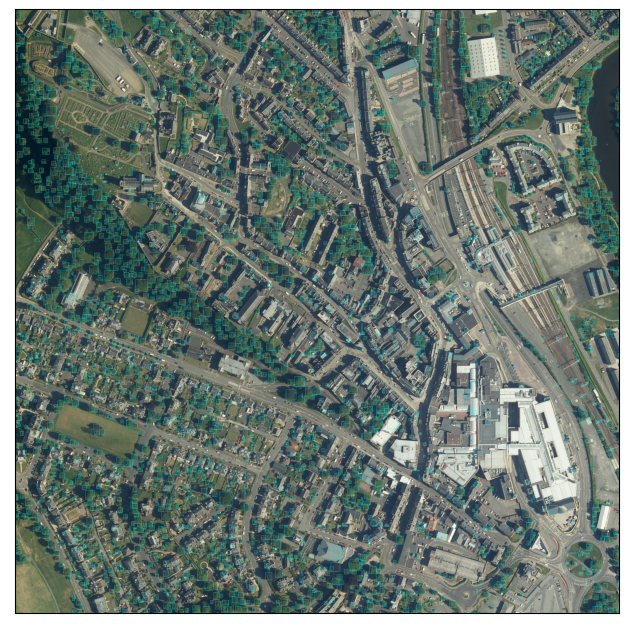

In [ ]:
plt.imshow(predicted_raster[:,:, ::-1])
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [ ]:
p = '/content/gdrive/MyDrive/Colab Notebooks/deepForest/data/prediction/predicted_rasterNOTRAINTHRESHOLD0.1.png'

cv2.imwrite(p, predicted_raster)

True

1. figure out test save
2. run evaluation
3. get logging working
4. setup hyperparameters
build loop to go through all cases




deepforest.utilities.annotations_to_shapefile(df, transform, crs)